In [1]:
import warnings
import struct
import sys
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.insert(0, '/glade/u/home/apinard/newldcpy/ldcpy')
import ldcpy

%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
warnings.filterwarnings("ignore")

# display the plots in this notebook
%matplotlib inline

os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [2]:
def get_data(compression_type, daily_variables, compression_levels):
    data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

    climate_var_arrays = {}

    for variable in daily_variables:
        print(variable)

        new_levels = [f"orig_{variable}"]
        new_sets = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]

        for value in compression_levels:
            if compression_type == "ZFP":
                new_level = f"zfp_p_{value}_{variable}"
                new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
            elif compression_type == "BG":
                new_level = f"bg_{value}_{variable}"
                new_set = f"{data_path}/daily_bg/bg_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"

            new_levels.append(new_level)
            new_sets.append(new_set)

        dataset = ldcpy.open_datasets("cam-fv", [f"{variable}"], new_sets, new_levels, chunks={})
        climate_var_arrays[variable] = np.array(dataset[variable].isel(time=0).values)

    return climate_var_arrays


def dec_to_binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))


def get_adj_bit(bit_pos):
    return [bit_pos[0] - 1, bit_pos[1]]


def get_dict_list(data_array, x_index):
    dict_list_H = []
    for i in range(N_BITS - 1):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = dec_to_binary(current_data)

            adj_data_index = get_adj_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = dec_to_binary(adj_data)

            for i in range(N_BITS - 1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])

                p00 = p01 = p10 = p11 = 0
                if adjacent_bit == 0 and current_bit == 0:
                    p00 = 1
                elif adjacent_bit == 1 and current_bit == 0:
                    p10 = 1
                elif adjacent_bit == 0 and current_bit == 1:
                    p01 = 1
                elif adjacent_bit == 1 and current_bit == 1:
                    p11 = 1

                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11

    return dict_list_H


def get_mutual_info(p00, p01, p10, p11):
    p0 = p00 + p10  # current bit is 0
    p1 = p11 + p01  # current bit is 1
    p0_prev = p00 + p01  # prev bit was 0
    p1_prev = p11 + p10  # prev bit was 1

    # From (4) in paper
    mutual_info = 0
    if p00 > 0:
        mutual_info += p00 * np.log2(p00 / p0_prev / p0)
    if p11 > 0:
        mutual_info += p11 * np.log2(p11 / p1_prev / p1)
    if p01 > 0:
        mutual_info += p01 * np.log2(p01 / p0_prev / p1)
    if p10 > 0:
        mutual_info += p10 * np.log2(p10 / p1_prev / p0)

    return mutual_info


def get_real_info(data_array, x_index):
    dict_list_H = get_dict_list(data_array, x_index)

    # Total number of recordings. Sum all counts for first dictionary
    num_measurements = np.sum(list(dict_list_H[0].values()))

    mutual_info_array = []
    for bit_pos_dict in dict_list_H:
        p00 = np.divide(bit_pos_dict["00"], num_measurements, dtype=np.float64)
        p01 = np.divide(bit_pos_dict["01"], num_measurements, dtype=np.float64)
        p10 = np.divide(bit_pos_dict["10"], num_measurements, dtype=np.float64)
        p11 = np.divide(bit_pos_dict["11"], num_measurements, dtype=np.float64)

        mutual_info = get_mutual_info(p00, p01, p10, p11)

        mutual_info_array.append(mutual_info)

    mutual_info_array = np.array(mutual_info_array)
    return mutual_info_array


def get_bit_cutoff(climate_var_array, percent_info=0.99):
    original_info = climate_var_array[0]

    original_info_sum = np.sum(original_info)

    for bit_pos in range(N_BITS-1):
        info_at_pos = np.sum(original_info[0:bit_pos])
        info_ratio_at_pos = info_at_pos / original_info_sum
        if info_ratio_at_pos >= percent_info:
            return bit_pos
    return None


def get_compression_level(climate_var_array, cutoff_bit, area_threshold=0.057):
    if not cutoff_bit:
        return None

    cutoff_bit += 1

    original_info = climate_var_array[0]
    original_info_sum = np.sum(original_info)

    best_compression_idx = -1
    for compression_index in range(1, climate_var_array.shape[0]):
        compressed_info = climate_var_array[compression_index]
        compressed_info_copy = deepcopy(compressed_info)
        compressed_info_copy[cutoff_bit:] = 0

        area_diff = np.sum(np.abs(compressed_info_copy - original_info))
        area_percent = area_diff / original_info_sum

        if area_percent < area_threshold:
            best_compression_idx = compression_index

    if best_compression_idx == -1:
        return None

    return best_compression_idx


def get_real_info_all(climate_var_arrays):
    climate_var_arrays_dict = {}
    for daily_variable in daily_variables:
        information_array = []
        arr = climate_var_arrays[daily_variable]

        for i in range(arr.shape[0]):
            mutual_info = get_real_info(arr, i)
            information_array.append(mutual_info)

        climate_var_arrays_dict[daily_variable] = np.array(information_array)

    return climate_var_arrays_dict


def plot_real_info(climate_var_arrays_dict, compression_levels, comp_name, y_max=0.85):
    compression_levels = [comp_name + "_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels
    for daily_variable in daily_variables:
        arr = climate_var_arrays_dict[daily_variable]

        cutoff = get_bit_cutoff(arr)
        print("Cutoff bit:", cutoff)

        compression_level_idx = get_compression_level(arr, cutoff)
        if compression_level_idx:
            compression_level = compression_levels[compression_level_idx]
            print("Compression Level:", compression_level)
        else:
            print("Compression Level: None")

        is_original = True
        for mutual_info in arr:
            if is_original:
                plt.plot(mutual_info, linewidth=4)
                is_original = False
            else:
                plt.plot(mutual_info, "--")

        plt.ylim((0, y_max))
        plt.title(f"{comp_name}: {daily_variable}")
        plt.xlabel("Bit Position")
        plt.ylabel("Real Information")
        plt.legend(compression_levels, bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
        plt.axvline(x=8)
        plt.show()

In [3]:
N_BITS = 32

# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html
daily_variables = [
    "TS",
    "PRECT",
    "LHFLX",
    "FLNS",
    "ICEFRAC",
    "PSL",
    "Q200",
    "TAUX",
    "WSPDSRFAV",
    "Z500"
]

In [4]:
# ZFP
zfp_compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]

zfp_climate_var_arrays = get_data("ZFP", daily_variables, zfp_compression_levels)
zfp_climate_var_arrays_dict = get_real_info_all(zfp_climate_var_arrays)

# plot_real_info(zfp_climate_var_arrays_dict, zfp_compression_levels, "ZFP")

TS
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

LHFLX
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62



In [5]:
# BG
bg_compression_levels = [7, 6, 5, 4, 3, 2]

bg_climate_var_arrays = get_data("BG", daily_variables, bg_compression_levels)
bg_climate_var_arrays_dict = get_real_info_all(bg_climate_var_arrays)

# plot_real_info(bg_climate_var_arrays_dict, bg_compression_levels, "BG")

TS
dataset size in GB 1.13

PRECT
dataset size in GB 1.13

LHFLX
dataset size in GB 1.13

FLNS
dataset size in GB 1.13

ICEFRAC
dataset size in GB 1.13

PSL
dataset size in GB 1.13

Q200
dataset size in GB 1.13

TAUX
dataset size in GB 1.13

WSPDSRFAV
dataset size in GB 1.13

Z500
dataset size in GB 1.13



In [6]:
def get_cutoff_bits_list(climate_var_arrays_dict, compression_levels):
    cutoff_bits_list = []
    for daily_variable in daily_variables:
        arr = climate_var_arrays_dict[daily_variable]

        cutoff = get_bit_cutoff(arr)
        cutoff_bits_list.append(cutoff)

    return cutoff_bits_list

In [7]:
df = pd.read_csv("~/lcr/data/daily/daily_zfp_bg_sz_comp_slices.csv")

In [8]:
def plot_real_info(climate_var_arrays_dict, compression_levels, comp_name, y_max=0.85):
    compression_levels = [comp_name + "_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels
    for daily_variable in daily_variables:
        arr = climate_var_arrays_dict[daily_variable]

        cutoff = get_bit_cutoff(arr)
        print("Cutoff bit:", cutoff)

        compression_level_idx = get_compression_level(arr, cutoff)
        if compression_level_idx:
            compression_level = compression_levels[compression_level_idx]
            print("Compression Level:", compression_level)
        else:
            print("Compression Level: None")

In [9]:
def get_compression_vars(climate_var_arrays_dict, compression_levels):
    compression_param_bg = []
    compression_levels = ["BG_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels
    for daily_variable in daily_variables:
        arr = climate_var_arrays_dict[daily_variable]

        cutoff = get_bit_cutoff(arr)

        compression_level_idx = get_compression_level(arr, cutoff)
        if compression_level_idx:
            compression_level = int(compression_levels[compression_level_idx][-1])
        else:
            compression_level = -1
        compression_param_bg.append(compression_level)

    return compression_param_bg

In [10]:
cutoff_bits_list = get_cutoff_bits_list(bg_climate_var_arrays_dict, bg_compression_levels)

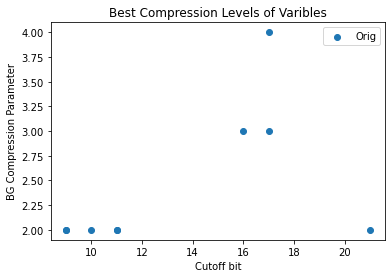

In [11]:
compression_param_bg = get_compression_vars(bg_climate_var_arrays_dict, bg_compression_levels)

plt.scatter(cutoff_bits_list, compression_param_bg)
plt.xlabel("Cutoff bit")
plt.ylabel("BG Compression Parameter")
plt.title("Best Compression Levels of Varibles")
plt.legend(["Orig"] + list(daily_variables))
plt.savefig("DSSIM.png")

In [12]:
def translate(input):
    if input <= 2:
        return 0
    elif input <= 5:
        return 1
    elif input <= 8:
        return 2
    elif input <= 12:
        return 3
    elif input <= 15:
        return 4
    elif input <= 18:
        return 5
    elif input <= 22:
        return 6
    return 7


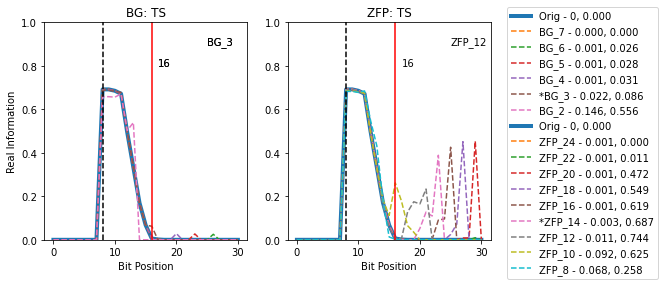

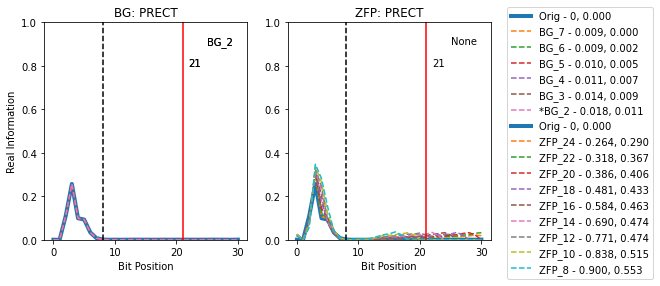

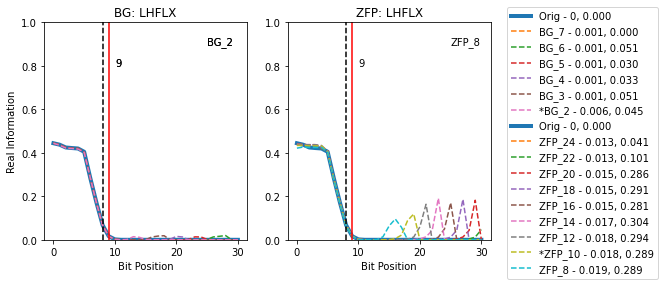

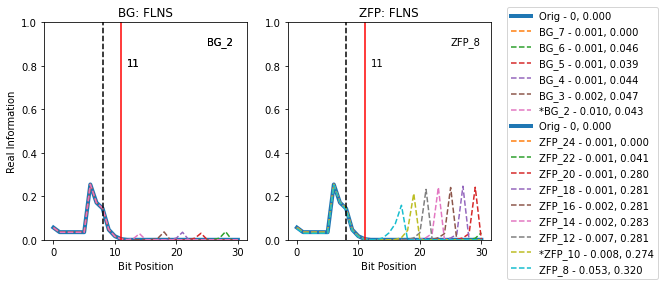

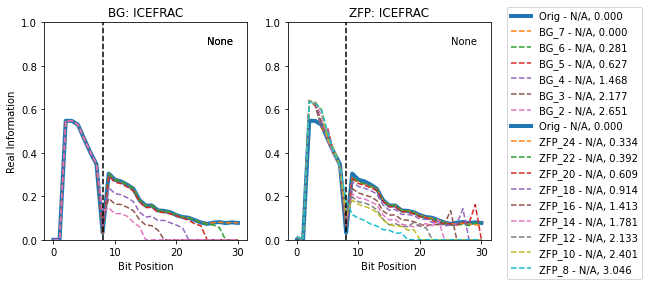

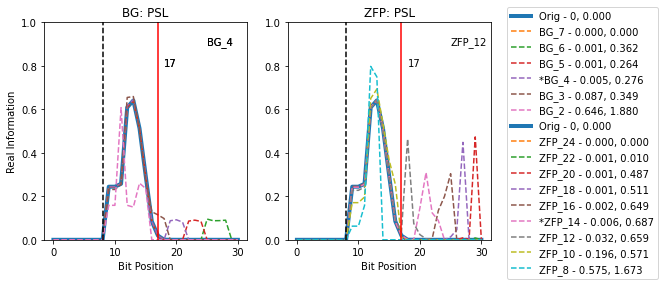

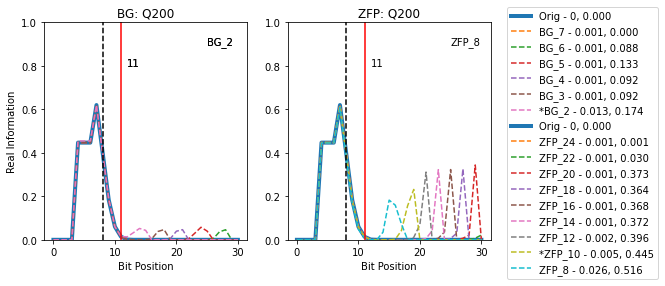

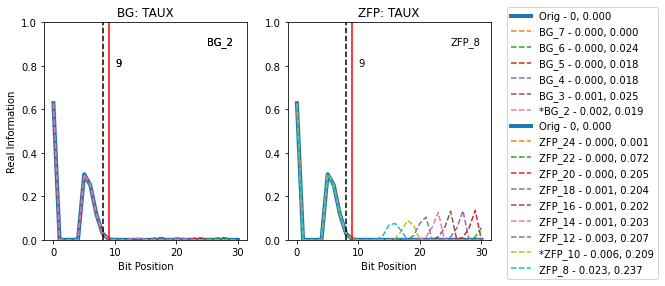

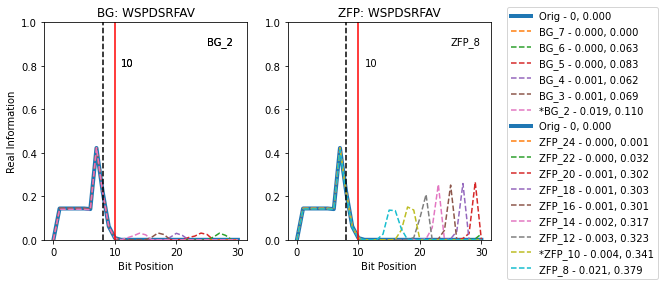

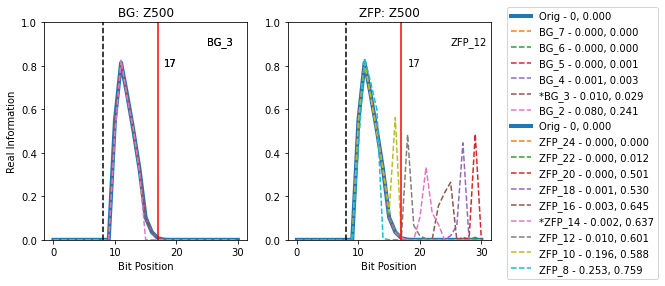

In [24]:
def get_similarities(climate_var_array, cutoff_bit, precision=3):
    if not cutoff_bit:
        return ["N/A"] * len(range(0, climate_var_array.shape[0]))

    cutoff_bit += 1

    original_info = climate_var_array[0]
    original_info_sum = np.sum(original_info)

    similarities = ["0"]

    for compression_index in range(1, climate_var_array.shape[0]):
        compressed_info = climate_var_array[compression_index]
        compressed_info_copy = deepcopy(compressed_info)
        compressed_info_copy[cutoff_bit:] = 0

        area_diff = np.sum(np.abs(compressed_info_copy - original_info))
        area_percent = area_diff / original_info_sum
        area_percent = ("{:." + str(precision) + "f}").format(area_percent)  # Wacky way to specify precision
        similarities.append(area_percent)

    return similarities
    

def get_artifacts_size(climate_var_array, precision=3):
    original_data = climate_var_array[0]
    artifacts_array = []

    for compression_index in range(climate_var_array.shape[0]):
        compressed_data = climate_var_array[compression_index]

        artifact = np.sum(np.abs(compressed_data - original_data))
        artifact = ("{:." + str(precision) + "f}").format(artifact)
        artifacts_array.append(artifact)

    return artifacts_array


def plot_bg_zfp(bg_climate_var_arrays_dict, bg_compression_levels, zfp_climate_var_arrays_dict, zfp_compression_levels, y_max=1):
    bg_compression_levels = ["BG" + "_" + str(x) for x in bg_compression_levels]
    zfp_compression_levels = ["ZFP" + "_" + str(x) for x in zfp_compression_levels]
    bg_compression_levels = ["Orig"] + bg_compression_levels
    zfp_compression_levels = ["Orig"] + zfp_compression_levels

    climate_var_arrays_array = [bg_climate_var_arrays_dict, zfp_climate_var_arrays_dict]
    compression_levels_array = [bg_compression_levels, zfp_compression_levels]

    for daily_variable in daily_variables:
        plt.figure(figsize=(8, 4))
        new_legend = []
        is_zfp = False
        for climate_var_arrays_dict, compression_levels, comp in zip(climate_var_arrays_array, compression_levels_array, ["BG", "ZFP"]):
            arr = climate_var_arrays_dict[daily_variable]
            cutoff = get_bit_cutoff(arr)
            similarities = get_similarities(arr, cutoff)
            artifacts_array = get_artifacts_size(arr)
            compression_level_idx = get_compression_level(arr, cutoff)

            if compression_level_idx:
                compression_level = compression_levels[compression_level_idx]
            else:
                compression_level = "None"
            plt.subplot(1, 2, is_zfp+1)
            is_original = True
            #print(arr)
            for mutual_info in arr:
                if is_original:
                    plt.plot(mutual_info, linewidth=4)
                    is_original = False
                elif comp == "BG" and is_zfp == True:
                    continue
                else:
                    plt.plot(mutual_info, "--")
                    
            i = 0
            for compression_level_iter, similarity, artifact in zip(compression_levels, similarities, artifacts_array):
                # if comp == "ZFP" and compression_level_iter == compression_levels[0]:
                #     continue  # Don't put orig in legend twice
                new_element = f"{compression_level_iter} - {similarity}, {artifact}"
                fixed_i = i
                if comp == "ZFP":
                    fixed_i += 1
                if fixed_i == compression_level_idx:
                    new_element = "*" + new_element
                new_legend.append(new_element)
                i += 1

            if not is_zfp:
                plt.ylabel("Real Information")
                plt.text(25, 0.9, compression_level)
                if cutoff:
                    plt.text(cutoff + 1, 0.8, str(cutoff))

            plt.ylim((0, y_max))
            plt.title(f"{comp}: {daily_variable}")
            plt.xlabel("Bit Position")
            plt.text(25, 0.9, compression_level)
            
            is_zfp = True
        
        # Legend
        plt.figlegend(new_legend, bbox_to_anchor=(0.92, 0.75, 0.3, 0.2), loc='upper left')
        
        # Add vertical lines
        is_zfp = False
        for climate_var_arrays_dict, compression_levels, comp in zip(climate_var_arrays_array, compression_levels_array, ["BG", "ZFP"]):
            plt.subplot(1, 2, is_zfp+1)
            is_zfp = True
            
            arr = climate_var_arrays_dict[daily_variable]
            cutoff = get_bit_cutoff(arr)
            plt.axvline(x=8, color='k', linestyle='--')
            
            if cutoff:
                plt.axvline(x=cutoff, color="r")
                plt.text(cutoff + 1, 0.8, str(cutoff))
                
        # Replot right graph to cover up
        # arr = bg_climate_var_arrays_dict[daily_variable]
        # is_original = True
        # plt.subplot(1, 2, 2)
        # for mutual_info in arr:
        #     if is_original:
        #         plt.plot(mutual_info, linewidth=4)
        #         is_original = False
        #     else:
        #         plt.plot(mutual_info, "--")
                
            
        # plt.show()
        plt.savefig(daily_variable + ".png", bbox_inches='tight')


plot_bg_zfp(bg_climate_var_arrays_dict, bg_compression_levels, zfp_climate_var_arrays_dict, zfp_compression_levels)

In [16]:
bg_compression_levels

[7, 6, 5, 4, 3, 2]

In [17]:
zfp_compression_levels

[24, 22, 20, 18, 16, 14, 12, 10, 8]

In [82]:
compression_levels[0]

NameError: name 'compression_levels' is not defined

In [68]:
bg_climate_var_arrays

{'TS': array([[[241.09251, 241.89992, 241.94568, ..., 241.84746, 241.078  ,
          241.99779],
         [241.76868, 241.86139, 242.53229, ..., 241.26796, 241.43243,
          241.3716 ],
         [242.0941 , 242.18382, 242.12163, ..., 242.14331, 242.17068,
          242.13554],
         ...,
         [237.1912 , 237.27914, 237.36772, ..., 236.92798, 237.01025,
          237.09695],
         [239.5857 , 239.6625 , 239.74104, ..., 239.39285, 239.44148,
          239.51059],
         [240.38441, 240.38661, 240.38863, ..., 240.3765 , 240.3794 ,
          240.38202]],
 
        [[241.09251, 241.89992, 241.94568, ..., 241.84746, 241.078  ,
          241.99779],
         [241.76868, 241.86139, 242.53229, ..., 241.26796, 241.43243,
          241.3716 ],
         [242.0941 , 242.18382, 242.12163, ..., 242.14331, 242.17068,
          242.13554],
         ...,
         [237.1912 , 237.27914, 237.36772, ..., 236.92798, 237.01025,
          237.09695],
         [239.5857 , 239.6625 , 239.74104, 

In [69]:
def get_Ms(bg_climate_var_arrays_dict, bg_compression_levels):
    bg_compression_levels = ["BG" + "_" + str(x) for x in bg_compression_levels]
    bg_compression_levels = ["Orig"] + bg_compression_levels

    Ms = []
    for daily_variable in daily_variables:
        arr = bg_climate_var_arrays_dict[daily_variable]

        M = sum(arr[0])
        Ms.append(M)

    return Ms


Ms = get_Ms(bg_climate_var_arrays_dict, bg_compression_levels)

for variable, M in zip(daily_variables, Ms):
    print(variable, M)

TS 3.8134080160726698
PRECT 0.6145490003474945
LHFLX 3.0936400477989703
FLNS 0.8693712555109111
ICEFRAC 6.058539670604272
PSL 2.909567884015697
Q200 2.6214378360005965
TAUX 1.3294183302789455
WSPDSRFAV 1.5763023950085189
Z500 3.004105867936048
